In [3]:
!pip install pytreebank
!pip install loguru
!pip install transformers

In [4]:
"""This module defines a configurable SSTDataset class."""

import pytreebank
import torch
from loguru import logger
from transformers import DistilBertTokenizer
from torch.utils.data import Dataset

logger.info("Loading the tokenizer")
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-cased")

logger.info("Loading SST")
sst = pytreebank.load_sst()


def rpad(array, n=70):
    """Right padding."""
    current_len = len(array)
    if current_len > n:
        return array[: n - 1]
    extra = n - current_len
    return array + ([0] * extra)


def get_binary_label(label):
    """Convert fine-grained label to binary label."""
    if label < 2:
        return 0
    if label > 2:
        return 1
    raise ValueError("Invalid label")


class SSTDataset(Dataset):
    """Configurable SST Dataset.
    
    Things we can configure:
        - split (train / val / test)
        - root / all nodes
        - binary / fine-grained
    """

    def __init__(self, split="train", root=True, binary=True):
        """Initializes the dataset with given configuration.

        Args:
            split: str
                Dataset split, one of [train, val, test]
            root: bool
                If true, only use root nodes. Else, use all nodes.
            binary: bool
                If true, use binary labels. Else, use fine-grained.
        """
        logger.info(f"Loading SST {split} set")
        self.sst = sst[split]

        logger.info("Tokenizing")
        if root and binary:
            self.data = [
                (
                    rpad(
                        tokenizer.encode("[CLS] " + tree.to_lines()[0] + " [SEP]"), n=66
                    ),
                    get_binary_label(tree.label),
                )
                for tree in self.sst
                if tree.label != 2
            ]
        elif root and not binary:
            self.data = [
                (
                    rpad(
                        tokenizer.encode("[CLS] " + tree.to_lines()[0] + " [SEP]"), n=66
                    ),
                    tree.label,
                )
                for tree in self.sst
            ]
        elif not root and not binary:
            self.data = [
                (rpad(tokenizer.encode("[CLS] " + line + " [SEP]"), n=66), label)
                for tree in self.sst
                for label, line in tree.to_labeled_lines()
            ]
        else:
            self.data = [
                (
                    rpad(tokenizer.encode("[CLS] " + line + " [SEP]"), n=66),
                    get_binary_label(label),
                )
                for tree in self.sst
                for label, line in tree.to_labeled_lines()
                if label != 2
            ]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        X, y = self.data[index]
        X = torch.tensor(X)
        return X, y


2020-04-30 02:58:46.432 | INFO     | __main__:<module>:9 - Loading the tokenizer


2020-04-30 02:58:47.553 | INFO     | __main__:<module>:12 - Loading SST


In [0]:
import os

import torch
from loguru import logger
from transformers import DistilBertConfig, DistilBertForSequenceClassification
from tqdm import tqdm

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train_one_epoch(model, lossfn, optimizer, dataset, batch_size=32):
    generator = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=True
    )
    model.train()
    train_loss, train_acc = 0.0, 0.0
    for batch, labels in tqdm(generator):
        batch, labels = batch.to(device), labels.to(device)
        optimizer.zero_grad()
        loss, logits = model(batch, labels=labels)
        err = lossfn(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        pred_labels = torch.argmax(logits, axis=1)
        train_acc += (pred_labels == labels).sum().item()
    train_loss /= len(dataset)
    train_acc /= len(dataset)
    return train_loss, train_acc


def evaluate_one_epoch(model, lossfn, optimizer, dataset, batch_size=32):
    generator = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=True
    )
    model.eval()
    loss, acc = 0.0, 0.0
    with torch.no_grad():
        for batch, labels in tqdm(generator):
            batch, labels = batch.to(device), labels.to(device)
            logits = model(batch)[0]
            error = lossfn(logits, labels)
            loss += error.item()
            pred_labels = torch.argmax(logits, axis=1)
            acc += (pred_labels == labels).sum().item()
    loss /= len(dataset)
    acc /= len(dataset)
    return loss, acc


def train(
    root=True,
    binary=False,
    bert="distilbert-base-cased",
    epochs=10,
    batch_size=32,
    save=False,
):
    trainset = SSTDataset("train", root=root, binary=binary)
    devset = SSTDataset("dev", root=root, binary=binary)
    testset = SSTDataset("test", root=root, binary=binary)

    # REMOVE BAD TRAINING DATA
    for x in trainset.data:
      if len(x[0]) != 66:
        trainset.data.remove(x)
    
    for x in devset.data:
      if len(x[0]) != 66:
        devset.data.remove(x)

    for x in testset.data:
      if len(x[0]) != 66:
        testset.data.remove(x)

    train_losses = []
    val_losses = []
    test_losses = []

    config = DistilBertConfig.from_pretrained(bert)
    if not binary:
        config.num_labels = 5
    model = DistilBertForSequenceClassification.from_pretrained(bert, config=config)

    model = model.to(device)
    lossfn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

    for epoch in range(1, epochs):
        train_loss, train_acc = train_one_epoch(
            model, lossfn, optimizer, trainset, batch_size=batch_size
        )
        val_loss, val_acc = evaluate_one_epoch(
            model, lossfn, optimizer, devset, batch_size=batch_size
        )
        test_loss, test_acc = evaluate_one_epoch(
            model, lossfn, optimizer, testset, batch_size=batch_size
        )
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        test_losses.append(test_loss)
        logger.info(f"epoch={epoch}")
        logger.info(
            f"train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, test_loss={test_loss:.4f}"
        )
        logger.info(
            f"train_acc={train_acc:.3f}, val_acc={val_acc:.3f}, test_acc={test_acc:.3f}"
        )
        if save and epoch%10 == 9:
            label = "binary" if binary else "fine"
            nodes = "root" if root else "all"
            torch.save(model, f"{bert}__{nodes}__{label}__e{epoch}.pickle")

    logger.success("Done!")
    return train_losses, val_losses, test_losses


In [6]:
train_losses, val_losses = train(root=True, binary=False, bert="distilbert-base-cased", save=True)

2020-04-30 02:59:07.939 | INFO     | __main__:__init__:54 - Loading SST train set
2020-04-30 02:59:07.940 | INFO     | __main__:__init__:57 - Tokenizing
2020-04-30 02:59:11.995 | INFO     | __main__:__init__:54 - Loading SST dev set
2020-04-30 02:59:11.996 | INFO     | __main__:__init__:57 - Tokenizing
2020-04-30 02:59:12.460 | INFO     | __main__:__init__:54 - Loading SST test set
2020-04-30 02:59:12.461 | INFO     | __main__:__init__:57 - Tokenizing


100%|██████████| 70/70 [00:08<00:00,  7.99it/s]
2020-04-30 03:01:39.139 | INFO     | __main__:train:101 - epoch=1
2020-04-30 03:01:39.140 | INFO     | __main__:train:103 - train_loss=0.0447, val_loss=0.0393, test_loss=0.0384
2020-04-30 03:01:39.141 | INFO     | __main__:train:106 - train_acc=0.360, val_acc=0.450, test_acc=0.473
100%|██████████| 70/70 [00:08<00:00,  7.95it/s]
2020-04-30 03:03:39.527 | INFO     | __main__:train:101 - epoch=2
2020-04-30 03:03:39.529 | INFO     | __main__:train:103 - train_loss=0.0362, val_loss=0.0380, test_loss=0.0364
2020-04-30 03:03:39.529 | INFO     | __main__:train:106 - train_acc=0.500, val_acc=0.476, test_acc=0.501
100%|██████████| 70/70 [00:08<00:00,  7.99it/s]
2020-04-30 03:05:39.866 | INFO     | __main__:train:101 - epoch=3
2020-04-30 03:05:39.868 | INFO     | __main__:train:103 - train_loss=0.0319, val_loss=0.0384, test_loss=0.0360
2020-04-30 03:05:39.868 | INFO     | __main__:train:106 - train_acc=0.563, val_acc=0.485, test_acc=0.490
100%|█████

In [0]:
import matplotlib.pyplot as plt

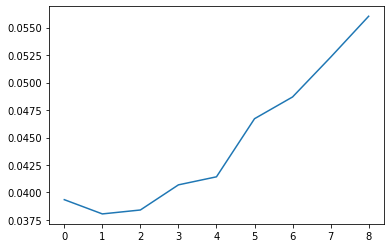

In [10]:
epoch = range(9)
plt.plot(epoch, val_losses)